## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [2]:
import string
import os
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [4]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
str = "";
for i in range(len(text)):
    str = str + text[i]

text = str.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


Получаем текст "Онегин"

In [9]:
if not os.path.exists('onegin.txt'):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
text = ''
with open('onegin.txt', 'r', encoding="utf8") as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

Тк у нас текст разбит на главы, мы можем их выделить, для этого научимся определять номер главы

In [44]:
def roman_char(s):
    chars = ["I", "V", "X", "L", "C", "D", "M", "(", ")"]
    valid = True
    for letter in s:
        if letter not in chars:
            valid = False
            break
    return valid

Опишем разделитель:

In [45]:
PAD = '_'

In [11]:
sonnets = []
sonnet = []
for line in text:
    if line.strip():
        if roman_char(line.strip()):
            sonnets.append(''.join(sonnet))
            sonnet = []
            continue
        sonnet.append(line.lstrip().lower())

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Форматируем текст в нижний регистр:

In [13]:
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

Формируем токены

In [15]:
tokens = set(text)
tokens.add(PAD)
tokens = sorted(tokens)
num_tokens = len(tokens)
assert num_tokens == 84

Выведем полученные токены и посмотрим на них:

In [16]:
print(*tokens)


   ! ( ) , - . 5 7 8 9 : ; ? [ ] ^ _ a b c d e f g h i k l m n o p q r s t u v w x y z « » а б в г д е ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я ё – — ’ … €


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

Реализация словарей

In [17]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i: c for i, c in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token_to_idx = {c: i for i, c in enumerate(tokens)}

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [46]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [19]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [20]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

Реализуем матрицу кодирования:

In [47]:
def matrix(token_to_idx, sequences, max_len=None, PAD='_'):
    max_len = max_len or max(map(len, sequences))
    sequences_ix = np.zeros([len(sequences), max_len], 'int32')

    for i in range(len(sequences)):
        line_ix = [token_to_idx[c] for c in sequences[i]]
        sequences_ix[i, :len(sequences[i])] = line_ix
        sequences_ix[i, len(sequences[i]):] = token_to_idx[PAD]

    return sequences_ix

Сам цикл обучения

In [21]:
def train_loop(model, loss_func, opt, n_epoch, num_tokens, train_loader):
    history = []
    for i in range(n_epoch):
        epoch_loss = []
        for batch_ix in train_loader:
            batch_ix = torch.tensor(batch_ix, dtype=torch.long).to(device)

            initial_state = model.initial_state(batch_size=batch_ix.shape[0])
            logits_seq, _ = model(batch_ix, initial_state)
            predictions_logits = logits_seq[:, :-1]
            actual_next_tokens = batch_ix[:, 1:]

            loss = loss_func(
                predictions_logits.reshape((-1, num_tokens)),
                actual_next_tokens.reshape(-1)
            )

            loss.backward()
            opt.step()
            opt.zero_grad()

            epoch_loss.append(loss.item())

        history.append(sum(epoch_loss) / len(epoch_loss))
        if (i + 1) % 100 == 0:
            clear_output(True)
            plt.plot(history, label='Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

    print(f'Final Loss: {history[-1]}')

Реализуем RNN модель:

In [26]:
class RNN(nn.Module):
    def __init__(self, input_size=84, hidden_size=64):
        super(self.__class__, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True).to(device)
        self.hid_to_logits = nn.Linear(hidden_size, input_size).to(device)

    def forward(self, x, h_state):
        emb = F.one_hot(x, self.input_size).float()
        h_seq, h_state = self.rnn(emb, h_state)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, h_state

    def initial_state(self, batch_size=1):
        if batch_size != 1:
            return torch.zeros(1, batch_size, self.hidden_size).to(device)
        else:
            return torch.zeros(batch_size, self.hidden_size).to(device)

cuda:0


In [27]:
train_loader = DataLoader(matrix(token_to_idx, sonnets), batch_size=32, shuffle=True)
len(tokens)

84

In [28]:
len(token_to_idx)

84

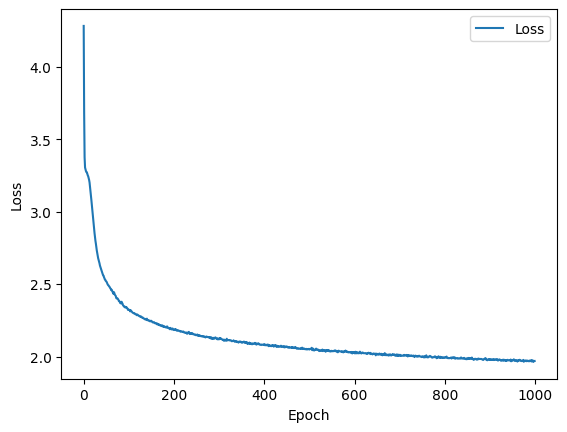

Final Loss: 1.9688992202281952


In [29]:
model_rnn = RNN(input_size=len(tokens))
opt = torch.optim.Adam(model_rnn.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx[PAD])
n_epoch = 1000

train_loop(
    model=model_rnn,
    loss_func=loss_func,
    opt=opt,
    n_epoch=n_epoch,
    num_tokens=num_tokens,
    train_loader=train_loader)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [30]:
MAX_LENGTH = 512

In [31]:
def generate_sample(char_rnn, seed_phrase='Hello', max_length=64, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    seed_phrase = seed_phrase.lower()

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state()

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, i].to(device), hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, -1].to(device), hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).cpu().data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # if next_ix == token_to_idx[EOS]:
        #     break
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [32]:
model_rnn.eval()

phrase = 'Когда'
print(phrase)
with torch.no_grad():
    for temperature in [0.3, 0.5, 0.8, 1]:
        print('')
        print('***')
        print(f'Temeprature: {temperature}')
        print(generate_sample(model_rnn, seed_phrase=phrase, max_length=128, temperature=temperature))


Когда

***
Temeprature: 0.3
когда по вылом потовельный
с от собо в своей пострать,
не в судно в столиный молой
так не володит не лено
в полно таня подруг мо

***
Temeprature: 0.5
когда пред не ль он вам просте свет.
она в суда стравит и должный,
с ней рассудим бестрать перей
и промно в сои не свительный,
и

***
Temeprature: 0.8
когда васну, подеверы жизно,
девелься вуди молчал, чет:
«пистоластве; уж глурить с могты
мни прострали душа полет,
и вечь кокоро

***
Temeprature: 1
когда болоть огниты пребрав»!
а грул кам пирок вотягловая,
всё токор увиру паечкил
он блюдливы савнет расподие,
и самея чисо рог


Получился в некотором смысле даже осмысленный и читаемый текст знаками препинания. Но в текстах не хватает деталей и какой-то более "человечной" связи между словами.
Для этого попробуем реализовать LSTM модель, немного отличную от RNN и сравним результаты.

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [36]:
class LSTM(nn.Module):
    def __init__(self, input_size=84, layers=2, hidden_size=64):
        super(self.__class__, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layers = layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True).to(device)
        self.hid_to_logits = nn.Linear(hidden_size, input_size).to(device)

    def forward(self, x, state):
        emb = F.one_hot(x, self.input_size).float()
        h_seq, state = self.lstm(emb, state)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, state

    def initial_state(self, batch_size=1):
        if batch_size != 1:
            return (torch.zeros(self.layers, batch_size, self.hidden_size).to(device), \
                    torch.zeros(self.layers, batch_size, self.hidden_size).to(device))
        else:
            return (torch.zeros(self.layers, self.hidden_size).to(device), \
                    torch.zeros(self.layers, self.hidden_size).to(device))

In [37]:
len(tokens)

84

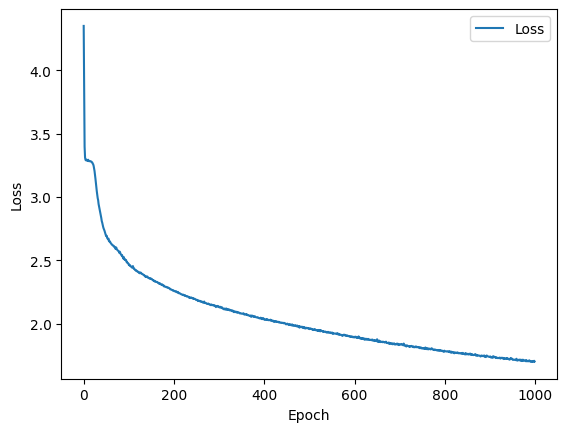

Final Loss: 1.7023503283659618


In [38]:
model_lstm = LSTM(input_size=len(tokens), layers=2)
opt = torch.optim.Adam(model_lstm.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx[PAD])
n_epoch = 1000

train_loop(
    model=model_lstm,
    loss_func=loss_func,
    opt=opt,
    n_epoch=n_epoch,
    num_tokens=num_tokens,
    train_loader=train_loader
)

Plot the loss function of the number of epochs. Does the final loss become better?

Финальный лосс для LSTM получился лучше, чем для RNN:

Final Loss LSTM: 1.7023
Final Loss RNN:  1.9688

Это дает надежду, что генерируемый текст будет более понятный.


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [42]:
model_lstm.eval()

phrase = 'Когда'
print(phrase)
with torch.no_grad():
    for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
        print('')
        print('***')
        print(f'Temeprature: {temperature}')
        print(generate_sample(model_lstm, seed_phrase=phrase, max_length=128, temperature=temperature))

Когда

***
Temeprature: 0.1
когда не последний столов,
и все в нем не простинный две,
к нему не видет она встренье
в полу в нем не последней,
и все в нем не

***
Temeprature: 0.2
когда не простите на стари,
в полу в отот полна своей
стару подного пред собою
и кольги в ней не показли
и думал не последанье
п

***
Temeprature: 0.5
когда не полка поредучи,
ее забавник ленской слуги
они пустом он все в селец,
как старинный старин полмнул.
а в своей терне и ст

***
Temeprature: 1.0
когда, полну; постал жира
вы, встреми вде млед, свои часа
влади в эту него ругу
уж был пустово рукаям
свесну пред болуши молоду,

***
Temeprature: 2.0
когдам отцир медло – и тымим
а срммиала, всшонда: семьи!
но юнемныйт прибылезвни?
«к,.: xn.-тёаю правслчли; —
бывантован… правил


Видно, что текст модели LSTM получился сильно лучше RNN. Также по тексту видно, что более высокая температура делает генерируемые тексты более разнообразными, добавляет туда более сложны знаки препинания и использует редкие символы.
Исходя из генерируемого текста, наиболее "лучший" результат, как мне кажется, получается при температуре 0,5 до 1.0, т.е. это будет лучший выбор, по сравнении с остальными вариантами.

Далее сохраним модели и воспроизведем получившиеся результаты еще раз.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [59]:
def model_save(model, name):
    path_to_save = name+'.pth'
    torch.save(model.state_dict(), path_to_save)

In [60]:
model_save(model_rnn, 'model_rnn')
model_save(model_lstm, 'model_lstm')

In [61]:
def load_model(model_loaded, path_to_save):
    torch_load = torch.load(path_to_save)
    model_loaded.load_state_dict(torch_load)

In [140]:
model_lstm = LSTM()
load_model(model_lstm, 'model_lstm.pth')

model_lstm.eval()
with torch.no_grad():
    print(generate_sample(model_lstm, seed_phrase='Так думал', max_length=156, temperature=0.8))

так думал ее шаму обкают,
до мне похарят о круга,
почтенник, разятся в молчанье?
как расслушливых нылавит.
онегин как в татьяна боль,
дале все ягины волнул.


In [146]:
model_rnn = RNN()
load_model(model_rnn, 'model_rnn.pth')

model_rnn.eval()
with torch.no_grad():
    print(generate_sample(model_rnn, seed_phrase='Так думал', max_length=156, temperature=0.5))

так думал старенных подова
я стот и так взлать деви
приходит он и так порой
он вот слагой четой делей.
стариной пред это ни поэт
и то взду на стростя поэт.



**Вывод:**

Результаты проделанной работы выглядят довольно неплохо. Тексты получаются со знаками препинания, словоформы построены корректно, многие слова написаны правильно, а если учесть, что мы в качестве токенов использовали символы, то получается совсем хорошо.
В целом также лучше себя показала сеть LSTM, которая чуть лучше, по моему мнению, справилась с заданием. В любом случае это было самое необычное задание и генерируемые тексты очень позабавили в процессе исследования.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.